In [61]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats
import pandas as pd

import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
figfolder = pathlib.PurePath('/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/poster/acute_stim')

In [63]:
session_info = {'date': "18_12_2023",
                'genotype_dir': 'R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f',
                'fly': 'fly1',
                'session': 'alternating_stim_points_2_6-001',
               }

In [64]:
gd = session_info['genotype_dir']
d = session_info['date']
f = session_info['fly']
s = session_info['session']




outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
y_epg = pp.timeseries['rois_z']
n_rois=y_epg.shape[1]

In [65]:
y = sp.ndimage.gaussian_filter1d(y_epg-1,.1,axis=1,mode='wrap')
# y = y_epg-1



In [66]:
mp = pp.metadata['mark_points']



stim_on_times = np.zeros((len(mp['custom_laser_power'])-1,))
stim_on_times += mp['initial_delay']+mp['duration']+mp['inter_point_delay']
stim_on_times = np.cumsum(stim_on_times)
stim_off_times = stim_on_times + mp['duration']

time = pp.voltage_recording_aligned['Time(ms)']

stim_mask = np.zeros_like(time)
for on,off in zip(stim_on_times, stim_off_times):
    stim_mask[(time>=on-1)&(time<=off)]=1
stim_mask = stim_mask>0

    

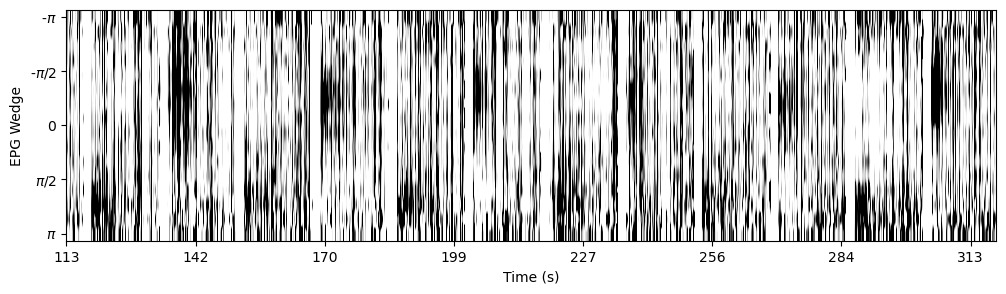

In [67]:
fig, ax= plt.subplots(figsize=[12,3])
yn = np.copy(y)
yn[:,:,stim_mask]=0
window = slice(1000,2800)
t = time[window]/1000
x = np.arange(t.shape[0])

ax.imshow(yn[1,:,window],aspect='auto', vmin=0, vmax=.4, cmap='Greys')
_ = ax.set_yticks([r/2/np.pi*15 for r in (0,  np.pi/2,  np.pi,  6*np.pi/4,  2*np.pi)], 
                    labels = [r'-$\pi$',  r'-$\pi$/2',  '0',  r'$\pi$/2',  r'$\pi$'])
_ = ax.set_xticks(x[::250], labels=[int(_t) for _t in t[::250]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EPG Wedge')

# gd = session_info['genotype_dir']
# d = session_info['date']
# f = session_info['fly']
# s = session_info['session']
fig.savefig(figfolder / f"{gd}_{d}_{f}_{s}.pdf")